<a href="https://colab.research.google.com/github/FrodoBaggins87/Machine_Learning/blob/main/Vision_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Preliminary Stuff

Making imports

In [3]:
#we need Torch 1.12 + and Torchvision 0.13 + for this study
try:
  import torch, torchvision
  assert int(torch.__version__.split(".")[1])>=12, "Torch version should be 1.12 or above"
  assert int(torchvision.__version__.split(".")[1])>=13, "Torch version should be 0.12 or above"
  print(f"Torch version:{torch.__version__}")
  print(f"torchvision version:{torchvision.__version__}")
except:
  print("Available libraries not updated, downloading updated libraries")
  !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
  import torch, torchvision
  print(f"Torch version:{torch.__version__}")
  print(f"torchvision version:{torchvision.__version__}")

Available libraries not updated, downloading updated libraries
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 75.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 73.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using 

Torch version:2.3.0+cu121
torchvision version:0.18.0+cu121


In [4]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torch import nn
from torchvision import transforms
try:
  from torchinfo import summary
except:
  !pip install -q torchinfo
  from torchinfo import summary

##Add previously written scripts

In [5]:
%%writefile data_setup.py
import os
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

NUM_WORKERS= os.cpu_count()
def create_dataloaders(
    train_dir: str,
    test_dir:str,
    train_transform: transforms.Compose,
    test_transform: transforms.Compose,
    batch_size:int,
    num_workers: int=NUM_WORKERS
):

  training_data=datasets.ImageFolder(root=train_dir, transform=train_transform)
  testing_data=datasets.ImageFolder(root=test_dir, transform=test_transform)
  class_names=training_data.classes
  train_dataloader=DataLoader(dataset=training_data,
                              batch_size=batch_size,#sample per dataloader
                              num_workers=num_workers,
                              shuffle=True,
                              pin_memory= True)
  test_dataloader=DataLoader(dataset=testing_data,
                            batch_size=batch_size,
                            num_workers=num_workers,
                            shuffle=False,
                            pin_memory= True)
  return train_dataloader, test_dataloader, class_names


Writing data_setup.py


In [6]:
%%writefile engine.py
import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple
def train_step(model:torch.nn.Module,
               dataloader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               optimizer:torch.optim.Optimizer,
              device: torch.device) -> Tuple[float, float]:
  #putting in training mode
  model.train()
  #setup training loss and training accuracy
  train_loss,train_acc=0,0

  for batch,(x,y) in enumerate(dataloader):
    #send data to target device
    x,y=x.to(device),y.to(device)
    #forward pass
    y_pred=model(x)
    #calculate and accumulate losses
    loss=loss_fn(y_pred,y)
    train_loss+=loss.item()
    #optimizer zero grad
    optimizer.zero_grad()
    #loss backward
    loss.backward()
    #optimizer step
    optimizer.step()

    #calculate and accumulate accuracy metric for all batches
    y_pred_class=torch.argmax(torch.softmax(y_pred,dim=1),dim=1)
    train_acc+=(y_pred_class==y).sum().item()/len(y_pred)

  #getting average loss and accuracy for each batch
  train_loss/=len(dataloader)
  train_acc/=len(dataloader)
  return train_loss, train_acc

def test_step(model:torch.nn.Module,
               dataloader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
              device: torch.device) -> Tuple[float,float]:
  #putting in eval mode
  model.eval()
  #setup test loss and test accuracy
  test_loss,test_acc=0,0
  #turn on inference context manager
  with torch.inference_mode():
    #loop through dataloader batches
    for batch,(x,y) in enumerate(dataloader):
      #send data to target device
      x,y=x.to(device),y.to(device)
      #forward pass
      test_pred_logits=model(x)
      #calculate and accumulate loss
      loss=loss_fn(test_pred_logits,y)
      test_loss+=loss.item()
      #calculate and accumulate accuracy
      test_pred_labels=torch.argmax(torch.softmax(test_pred_logits,dim=1),dim=1)
      test_acc+=(test_pred_labels==y).sum().item()/len(test_pred_labels)#can probably also use len(test_pred), not sure both should work i think
  #getting average loss and accuracy for each batch
  test_acc/=len(dataloader)
  test_loss/=len(dataloader)
  return test_loss, test_acc

#defining functions and various required parameters
def train(model:torch.nn.Module,
          train_dataloader:torch.utils.data.DataLoader,
          test_dataloader:torch.utils.data.DataLoader,
          optimizer:torch.optim.Optimizer,
          loss_fn:torch.nn.Module,
          epochs: int,
        device: torch.device) -> Dict[str, list]:
  #create empty results dictionary
  results={"train_loss":[],
           "test_loss":[],
           "train_acc":[],
           "test_acc":[]}
  #looping through train_step() and test_step()
  for epoch in tqdm(range(epochs)):
    train_loss,train_acc=train_step(model=model,
                                    dataloader=train_dataloader,
                                    loss_fn=loss_fn,
                                    optimizer=optimizer,
                                    device=device)
    test_loss, test_acc=test_step(model=model,
                                  dataloader=test_dataloader,
                                  loss_fn=loss_fn,
                                  device=device)
  #print whats happening
    print(
        f"Epoch:{epoch+1}|"
        f"Train Loss:{train_loss:.4f}|"
        f"Training Accuracy: {train_acc:.4f}|"
        f"Test Loss: {test_loss:.4f}|"
        f"Test Accuracy: {test_acc:.4f}"
    )
    #updating result dictionary
    results["train_loss"].append(train_loss)
    results["test_loss"].append(test_loss)
    results["train_acc"].append(train_acc)
    results["test_acc"].append(test_acc)
  return results


Writing engine.py


In [7]:
%%writefile utils.py
import torch
from pathlib import Path
def save_model(model:torch.nn.Module,
               target_dir: str,
               model_name:str):
  #creating target directory
  target_dir_path=Path(target_dir)
  target_dir_path.mkdir(parents=True,
                        exist_ok=True)
  #creating model save path
  assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
  model_save_path = target_dir_path/model_name

  #save the model state_dict
  print(f"Saving model to:{model_save_path}")
  torch.save(obj=model.state_dict(),
             f=model_save_path)

Writing utils.py


##Device agnostic code

In [8]:
device='cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

##Make function to set seeds

In [9]:
#set seeds
def set_seeds(seed:int=69):
  "set seed whenver required before torch operations. Default seed = 69"
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)

##Download data

In [10]:
import requests
import zipfile
from pathlib import Path
import os
def download_data(source:str,
                  destination:str,
                  remove_source:bool=True)->Path:
  #setup path to data folder
  data_path= Path("data/")
  image_path=data_path/destination
  #check if image folder exists or not, if not prepare it
  if image_path.is_dir():
    print(f"{image_path} directory exists")
  else:
    print(f"Didnt find {image_path}, creating...")
    image_path.mkdir(parents=True, exist_ok=True)
    #the datset that will be used is a formatted dataset being taken from a github file, in general, wont get such formatted data
    #download pizza, steak, sushi data in zip file
    target_file=Path(source).name
    with open(data_path/target_file,"wb") as f:
      request = requests.get(source)
      print("Downloading data...")
      f.write(request.content)
    #unzip data
    with zipfile.ZipFile(data_path/target_file,"r") as zip_ref:
      print("Unzipping food_stuff file...")
      zip_ref.extractall(image_path)
    if remove_source:
      os.remove(data_path/target_file)
  return image_path
image_path=download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip", destination='pizza_steak_sushi')
image_path

Didnt find data/pizza_steak_sushi, creating...
Unzipping food_stuff file...


PosixPath('data/pizza_steak_sushi')

In [11]:
!ls data/pizza_steak_sushi

test  train


setup paths to training and testing data


In [12]:
#creating paths to train and test directories
train_dir=image_path/"train"
test_dir=image_path/"test"

##Create transforms and dataloaders

Creating appropriate transforms

In [13]:
IMG_SIZE=224
manual_transform=transforms.Compose([transforms.Resize((IMG_SIZE,IMG_SIZE)),
                                     transforms.ToTensor()])
print(f'manually created transofrm is : {manual_transform}')

manually created transofrm is : Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


Create dataloaders

In [14]:
from data_setup import create_dataloaders
#setting batch size
BATCH_SIZE=32#GOOGLE COLAB FREE GPU WONT BE ABLE TO HANDLE MUCH BIGGER BATCH SIZES THAN THIS
train_dataloader,test_dataloader, class_names=create_dataloaders(train_dir=train_dir,
                                                                 test_dir=test_dir,
                                                                 train_transform=manual_transform,
                                                                 test_transform=manual_transform,
                                                                 batch_size=BATCH_SIZE)

Visualize the dataloaders and individual images

In [15]:
next(iter(train_dataloader))

[tensor([[[[0.7020, 0.6980, 0.7137,  ..., 0.7255, 0.7333, 0.7373],
           [0.6902, 0.7020, 0.7020,  ..., 0.7059, 0.7294, 0.7294],
           [0.6588, 0.6784, 0.6824,  ..., 0.7020, 0.7098, 0.7098],
           ...,
           [0.3882, 0.4039, 0.4157,  ..., 0.5569, 0.5176, 0.4627],
           [0.3333, 0.3882, 0.4353,  ..., 0.5647, 0.5255, 0.4941],
           [0.3176, 0.3373, 0.4000,  ..., 0.5255, 0.5137, 0.5059]],
 
          [[0.7059, 0.7020, 0.7137,  ..., 0.7059, 0.7059, 0.7059],
           [0.6980, 0.7137, 0.7098,  ..., 0.6824, 0.7020, 0.6941],
           [0.6745, 0.6941, 0.6941,  ..., 0.6784, 0.6863, 0.6784],
           ...,
           [0.2510, 0.2627, 0.2627,  ..., 0.4235, 0.3804, 0.3216],
           [0.2000, 0.2510, 0.2863,  ..., 0.4235, 0.3843, 0.3529],
           [0.1882, 0.2039, 0.2588,  ..., 0.3843, 0.3725, 0.3647]],
 
          [[0.5843, 0.5882, 0.6235,  ..., 0.5569, 0.5608, 0.5608],
           [0.5882, 0.6078, 0.6196,  ..., 0.5451, 0.5647, 0.5608],
           [0.5765, 0.60

In [16]:
sample_image_batch, sample_label_batch=next(iter(train_dataloader))
image, label=sample_image_batch[0], sample_label_batch[0]
image.shape,label

(torch.Size([3, 224, 224]), tensor(2))

(-0.5, 223.5, 223.5, -0.5)

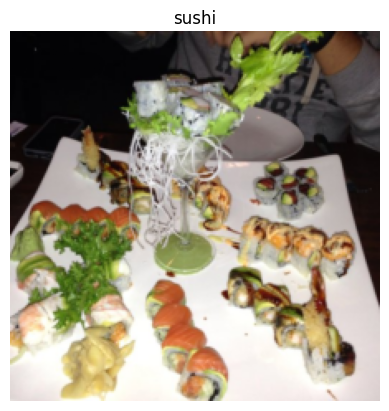

In [17]:
#plot individual image
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

##Make Patch and Position Embedding layer(Complete Equation 1)

Calculating patch embedding shape

In [18]:
#create sample values
height=224
width=224
patch_size=16
color_channel=3
number_of_patches= int(height*width/patch_size**2)
print(f"for image of dimensions{color_channel}x{height}x{width}(CxHxW), embedding with patch size {patch_size} has dimensions {number_of_patches}x{patch_size**2 * color_channel}(NxP^2*C)")

for image of dimensions3x224x224(CxHxW), embedding with patch size 16 has dimensions 196x768(NxP^2*C)


In [19]:
embedding_layer_input_shape=(color_channel,height,width)
embedding_layer_output_shape=(number_of_patches, patch_size**2 * color_channel)
print("embedding_layer_input_shape=",embedding_layer_input_shape)
print("embedding_layer_output_shape=",embedding_layer_output_shape)

embedding_layer_input_shape= (3, 224, 224)
embedding_layer_output_shape= (196, 768)


Visualize single image

(-0.5, 223.5, 223.5, -0.5)

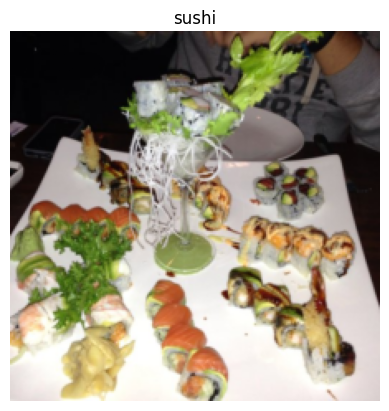

In [20]:
#plot after changing dimension accoriding to matplotlib
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

(-0.5, 223.5, 15.5, -0.5)

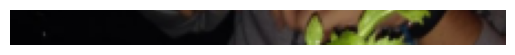

In [21]:
#visualizing taking just patches of the topmost layer
image_permuted=image.permute(1,2,0)
plt.imshow(image_permuted[:patch_size,:,:])
plt.axis(False)

Creating series of subplots for top layer of image

number of patches in 1 row=14


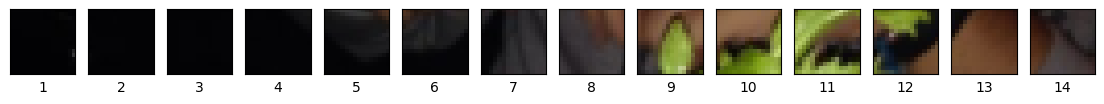

In [22]:
image_size=224
patch_size=16
num_patches=int(image_size/patch_size)
assert image_size%patch_size== 0, "image size is not divisible by patch size"
print(f"number of patches in 1 row={num_patches}")
#making series of plots
fig,axs=plt.subplots(nrows=1,
                     ncols=num_patches,
                     figsize=(num_patches, num_patches),# WHY IS FIGSIZE NUM_PATCHES
                     sharex=True,
                     sharey=True)
#iterating through patches in top row
for i,patch in enumerate(range(0,image_size, patch_size)): #enumerate is only used because also needed index i
  axs[i].imshow(image_permuted[:patch_size,patch:patch+patch_size,:])
  axs[i].set_xlabel(i+1)
  axs[i].set_xticks([])
  axs[i].set_yticks([])

Creating series of subplots for whole image

number of patches in 1 row:14
 number of patches in 1 column:14
 total nnumber of patches: 196
 patch size:16x16


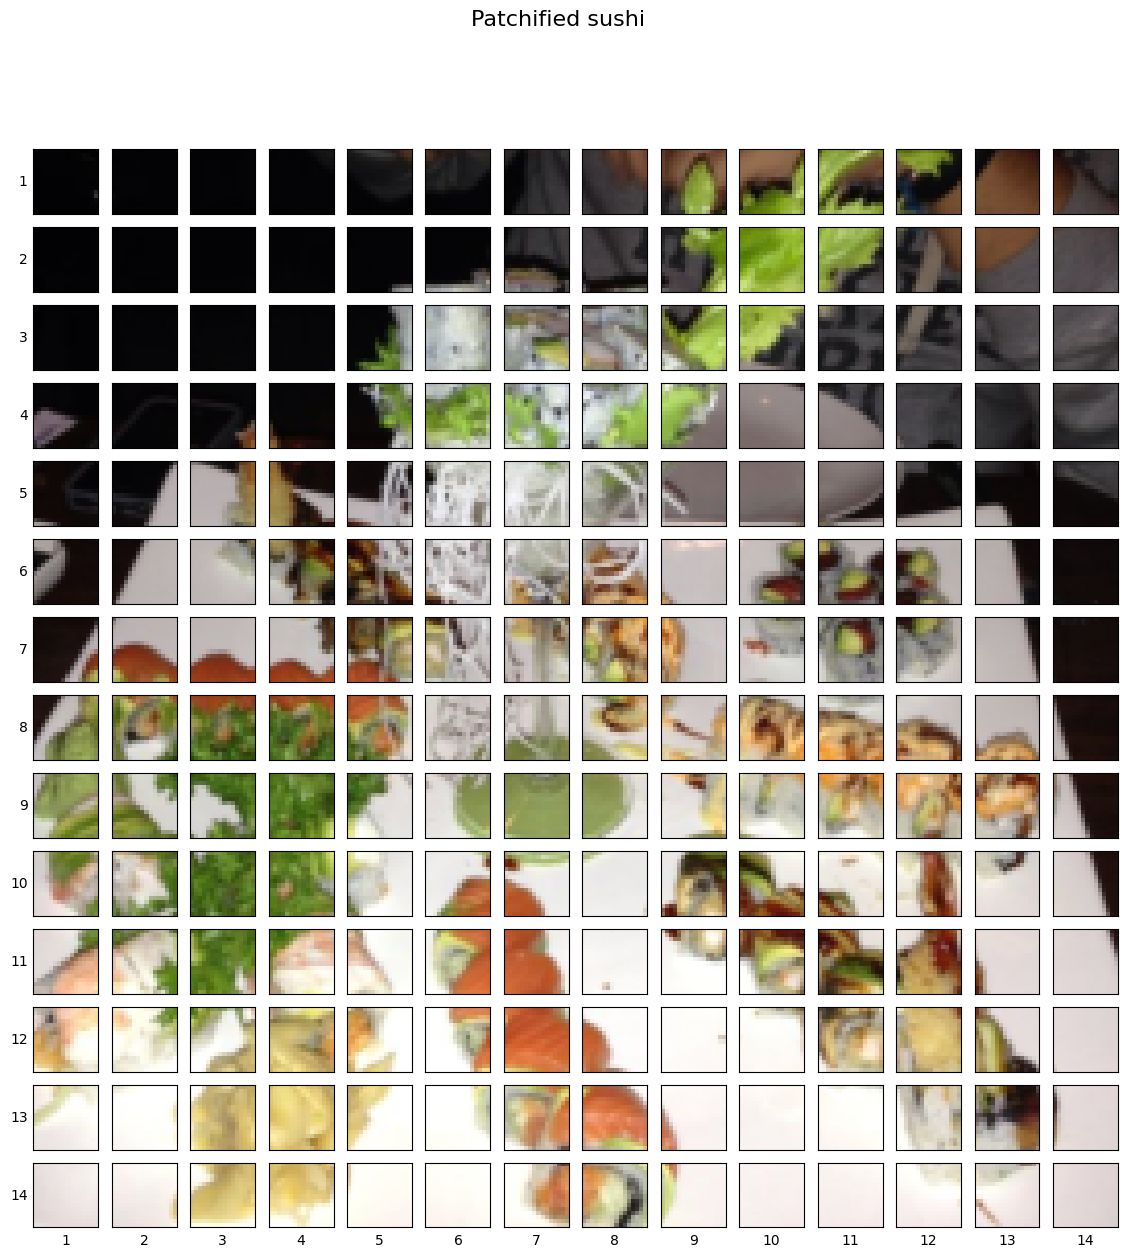

In [23]:
image_size=224
patch_size=16
num_patches=int(image_size/patch_size)
assert image_size%patch_size== 0, "image size is not divisible by patch size"
print(f"number of patches in 1 row:{num_patches}\n number of patches in 1 column:{num_patches}\n total nnumber of patches: {num_patches**2}\n patch size:{patch_size}x{patch_size}")
#making series of subplots
fig,axs=plt.subplots(nrows=num_patches,
                     ncols=num_patches,
                     figsize=(num_patches, num_patches),# WHY IS FIGSIZE NUM_PATCHES
                     sharex=True,
                     sharey=True)

#iterating through all patches
for i, patch_height in enumerate(range(0, image_size, patch_size)):
  for j,patch_width in enumerate(range(0,image_size, patch_size)):
    axs[i,j].imshow(image_permuted[patch_height:patch_height+patch_size,#for selecting the row of patches
                                   patch_width:patch_width+patch_size,#for selecting the column of patches
                                   :])#for all color channels
    axs[i,j].set_ylabel(i+1,
                        rotation='horizontal',
                        horizontalalignment='right',
                        verticalalignment='center')
    axs[i,j].set_xlabel(j+1)
    axs[i,j].set_xticks([])
    axs[i,j].set_yticks([])
    axs[i,j].label_outer()

fig.suptitle(f"Patchified {class_names[label]}", fontsize=16)
plt.show()

Making patches using CNN layers rather than manually

In [24]:
from torch import nn
#making CNN layer to convert a patch into D- dimensional vector which will be the patch embedding
patch_size=16

conv2d=nn.Conv2d(in_channels=3,#number of color channels
                 out_channels=768,#from table 1 in paper, the base model has hidden size D=786
                 stride=patch_size,
                 kernel_size=patch_size,
                 padding=0)


In [25]:
#passing through single image to see what happens
print(image.shape)
image_through_CNN=conv2d(image)
print(image_through_CNN.shape)
image_with_batchsize_through_CNN=conv2d(image.unsqueeze(0))
print(image_with_batchsize_through_CNN.shape)

torch.Size([3, 224, 224])
torch.Size([768, 14, 14])
torch.Size([1, 768, 14, 14])


Visualizing the patch embeddings

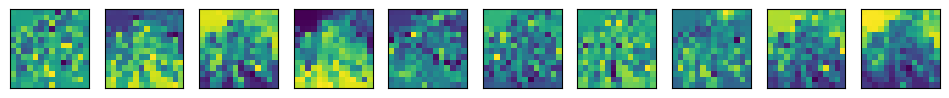

In [26]:
import random
random_index=random.sample(range(0,786),k=10)#selecting 10 random samples

#create plot
fig,axs=plt.subplots(nrows=1,ncols=10, figsize=(12,12))

#plotting random feature maps
for i, index in enumerate(random_index):
  image_conv_feature_map=image_with_batchsize_through_CNN[:,index,:,:]
  axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())#normally a tensor has requires_grad attribute associated with it, on using detach method, this attribute gets removed and we have just the tensor which can be shofted to cpu if needed
  axs[i].set(xticklabels=[],yticklabels=[],xticks=[],yticks=[])


In [27]:
#get single feature map in tensor form
single_map=image_with_batchsize_through_CNN[:,0,:,:]
single_map, single_map.requires_grad #checking requires_grad to make sure that the tensor values will be updated during training

(tensor([[[-5.6664e-03, -3.4828e-03, -1.9839e-03, -1.4451e-03, -5.5840e-02,
           -1.0954e-01,  9.6280e-03, -4.8991e-02, -9.3003e-02, -1.0284e-01,
           -1.0956e-01, -2.6452e-01,  3.1179e-02, -2.2701e-02],
          [ 1.6704e-03,  1.0132e-04,  5.0156e-04, -3.3380e-04,  1.1490e-01,
            2.2998e-01, -7.5868e-02, -7.8242e-02, -3.7456e-02,  3.8933e-04,
           -3.9676e-01, -7.1401e-02, -1.3322e-01, -1.2419e-01],
          [-1.0980e-03, -2.3804e-03, -1.1900e-03, -3.9918e-03,  2.3106e-01,
           -4.5524e-01, -4.3654e-02, -2.2673e-01,  1.4158e-01, -3.3967e-01,
           -1.3978e-01, -1.0909e-01, -1.0850e-01, -1.8309e-01],
          [ 2.9854e-02, -2.6151e-02,  3.3532e-02,  7.0949e-03,  8.7086e-02,
           -6.8862e-02, -1.2293e-01, -3.4547e-01, -4.5644e-01, -2.9186e-01,
           -9.2170e-02, -1.8070e-01, -9.2688e-02, -1.2339e-01],
          [ 8.3563e-04,  2.2941e-01, -3.4760e-01, -2.7547e-02, -1.4906e-02,
           -3.7076e-01, -4.7537e-01, -2.9315e-01, -1.1123e-0

Flattening patch embeddings

In [28]:
#current shape of image
image_with_batchsize_through_CNN.shape

torch.Size([1, 768, 14, 14])

In [29]:
#dont need to flatten the entire tensor just the height and width of the feature map, so need to flatten the last 2 dimensions of the tensor.
flatten=nn.Flatten(start_dim=2,
                   end_dim=3)#flattening from indices 2 to 3 of the tensor we get after passing through the CNN

Putting it all together

Original image shape: torch.Size([3, 224, 224])
Shape after CNN:torch.Size([1, 768, 14, 14])
Flattened shape:torch.Size([1, 768, 196])


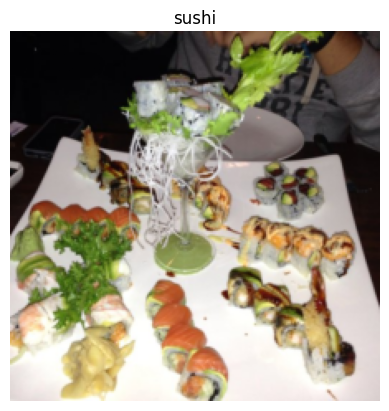

In [30]:
#plotting single image
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)
print(f"Original image shape: {image.shape}")
#passing through CNN
image_after_CNN=conv2d(image.unsqueeze(0))
print(f"Shape after CNN:{image_after_CNN.shape}")
#flattening
flattened_image_after_CNN=flatten(image_after_CNN)
print(f"Flattened shape:{flattened_image_after_CNN.shape}")

(-0.5, 195.5, 0.5, -0.5)

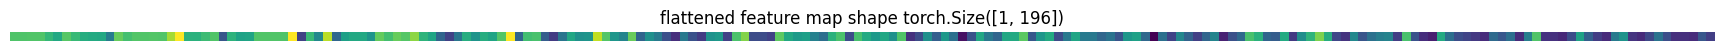

In [31]:
#our embedding should have dimension 196x786
#the CNN extracts 768 features out of 1 patch, so, we get 786 different 14x14 feature maps, then these maps have been flattened so we get 786 flattened feature maps of dimension 196, now we select one of these 786 feature maps to visualize
single_feature_map=flattened_image_after_CNN.permute(0,2,1)[:,:,0]

#plot flattened feature map
plt.figure(figsize=(22,22))
plt.imshow(single_feature_map.detach().numpy())
plt.title(f"flattened feature map shape {single_feature_map.shape}")
plt.axis(False)

In [32]:
single_feature_map,single_feature_map.shape, single_feature_map.requires_grad

(tensor([[-5.6664e-03, -3.4828e-03, -1.9839e-03, -1.4451e-03, -5.5840e-02,
          -1.0954e-01,  9.6280e-03, -4.8991e-02, -9.3003e-02, -1.0284e-01,
          -1.0956e-01, -2.6452e-01,  3.1179e-02, -2.2701e-02,  1.6704e-03,
           1.0132e-04,  5.0156e-04, -3.3380e-04,  1.1490e-01,  2.2998e-01,
          -7.5868e-02, -7.8242e-02, -3.7456e-02,  3.8933e-04, -3.9676e-01,
          -7.1401e-02, -1.3322e-01, -1.2419e-01, -1.0980e-03, -2.3804e-03,
          -1.1900e-03, -3.9918e-03,  2.3106e-01, -4.5524e-01, -4.3654e-02,
          -2.2673e-01,  1.4158e-01, -3.3967e-01, -1.3978e-01, -1.0909e-01,
          -1.0850e-01, -1.8309e-01,  2.9854e-02, -2.6151e-02,  3.3532e-02,
           7.0949e-03,  8.7086e-02, -6.8862e-02, -1.2293e-01, -3.4547e-01,
          -4.5644e-01, -2.9186e-01, -9.2170e-02, -1.8070e-01, -9.2688e-02,
          -1.2339e-01,  8.3563e-04,  2.2941e-01, -3.4760e-01, -2.7547e-02,
          -1.4906e-02, -3.7076e-01, -4.7537e-01, -2.9315e-01, -1.1123e-01,
          -1.9083e-01, -1

Putting the whole embedding layer in one subclass of nn.Module

In [33]:
class PatchEmbeddingClass(nn.Module):
  #Takes input a 2D image, converts into flattened learnable feature map to feed into the neural network

  #initialize the class
  def __init__(self,
             in_channels=3,
             patch_size=16,
             embedding_dim=768):
    super().__init__()

    #create layer to make patches
    self.patcher=nn.Conv2d(in_channels=in_channels,
                           out_channels=embedding_dim,
                           stride=patch_size,
                           kernel_size=patch_size,
                           padding=0)#make sure input is unsqueezed so one dimension represents batch size

    #create flattening layer
    self.flatten=nn.Flatten(start_dim=2,
                   end_dim=3)
  def forward(self,x):
    #assert a shape of image that makes sense
    original_image_shape=x.shape[-1]#can also be x.shape[-2]
    assert original_image_shape % patch_size ==0, "Patch size should be selected such that image shape is divisible by it"

    #perform forward pass
    flattened_x=self.flatten(self.patcher(x))

    #return the permuted feature map
    return flattened_x.permute(0,2,1)#this puts the embedding in the final dimension

In [34]:
#trying it out
set_seeds()
sample_embedding_layer=PatchEmbeddingClass(in_channels=3,
                                          patch_size=16,
                                          embedding_dim=768)
#pass a single image thorugh
print(f"Input shape={image.unsqueeze(0).shape}")
image_after_embedding=sample_embedding_layer(image.unsqueeze(0))
print(f"Output shape={image_after_embedding.shape}")

Input shape=torch.Size([1, 3, 224, 224])
Output shape=torch.Size([1, 196, 768])


get summary of embedding layer

In [35]:
summary(PatchEmbeddingClass(),input_size=(1,3,224,224),col_names=['input_size','output_size','num_params','trainable'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
PatchEmbeddingClass                      [1, 3, 224, 224]          [1, 196, 768]             --                        True
├─Conv2d: 1-1                            [1, 3, 224, 224]          [1, 768, 14, 14]          590,592                   True
├─Flatten: 1-2                           [1, 768, 14, 14]          [1, 768, 196]             --                        --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
Total mult-adds (M): 115.76
Input size (MB): 0.60
Forward/backward pass size (MB): 1.20
Params size (MB): 2.36
Estimated Total Size (MB): 4.17

In [36]:
#Uncomment following line of code to see what happens when wrong dimension is used
#summary(PatchEmbeddingClass(),input_size=(1,3,230,230),col_names=['input_size','output_size','num_params','trainable'])

Making class token embedding

In [37]:
print(image_after_embedding)
print(f"Shape is:{image_after_embedding.shape}")

tensor([[[ 1.4978e-02, -6.6516e-03, -2.5839e-02,  ..., -2.0967e-02,
           4.2115e-02,  6.7083e-03],
         [ 8.1429e-03,  6.0694e-04, -3.7343e-02,  ..., -2.3952e-02,
           3.1428e-02, -1.1808e-02],
         [ 6.6107e-03,  3.2562e-03, -3.9290e-02,  ..., -2.4329e-02,
           3.2672e-02, -1.1369e-02],
         ...,
         [-8.3577e-01, -3.2490e-01, -3.5174e-01,  ...,  7.1471e-01,
           8.8558e-01,  4.1156e-01],
         [-7.1108e-01, -2.6010e-01, -3.1323e-01,  ...,  6.7050e-01,
           8.6619e-01,  3.2903e-01],
         [-7.3892e-01, -2.7925e-01, -3.2220e-01,  ...,  6.0606e-01,
           8.0550e-01,  3.9301e-01]]], grad_fn=<PermuteBackward0>)
Shape is:torch.Size([1, 196, 768])


In [38]:
#To add a class token embedding we need to make an embedding of size 786 and add it to the number_of_patches dimension
#will make a torch.randn() tensor of dimension [batch_size, 1, embedding_dim] and prepend it in dim=1 of image_after_embedding
batch_size=image_after_embedding.shape[0]
embedding_dimensions=image_after_embedding.shape[-1]

#create class token
set_seeds()
class_token=nn.Parameter(torch.randn(batch_size,1,embedding_dimensions), requires_grad=True)

#visualize class token
print(class_token[:,:,:10])

#print class token shape
print(f"Class token shape is:{class_token.shape} [batch size, 1, embedding dimensions]")

tensor([[[-0.5300, -1.3035,  0.4438,  1.2221,  1.0395,  0.9608,  0.4214,
           0.7452, -1.8389, -1.2497]]], grad_fn=<SliceBackward0>)
Class token shape is:torch.Size([1, 1, 768]) [batch size, 1, embedding dimensions]


In [39]:
class_and_patch_embedding=torch.cat((class_token,image_after_embedding), dim=1)
print(class_and_patch_embedding[:,:,:10])
print(f"Shape is:{class_and_patch_embedding.shape}")

tensor([[[-5.3001e-01, -1.3035e+00,  4.4381e-01,  ...,  7.4521e-01,
          -1.8389e+00, -1.2497e+00],
         [ 1.4978e-02, -6.6516e-03, -2.5839e-02,  ..., -1.1229e-02,
          -2.2425e-02, -1.0264e-02],
         [ 8.1429e-03,  6.0694e-04, -3.7343e-02,  ..., -1.6314e-02,
          -2.0199e-02, -2.6279e-02],
         ...,
         [-8.3577e-01, -3.2490e-01, -3.5174e-01,  ...,  8.2415e-01,
           2.4180e-01,  1.5267e-01],
         [-7.1108e-01, -2.6010e-01, -3.1323e-01,  ...,  7.7236e-01,
           2.3366e-01,  1.6735e-01],
         [-7.3892e-01, -2.7925e-01, -3.2220e-01,  ...,  7.2321e-01,
           1.5422e-01,  1.7333e-01]]], grad_fn=<SliceBackward0>)
Shape is:torch.Size([1, 197, 768])


Make position embedding

In [40]:
set_seeds()
position_embedding=nn.Parameter(torch.rand(class_and_patch_embedding.shape), requires_grad=True)
print(f"Shape of position embedding is: {position_embedding.shape}")
print(position_embedding[:,0,:10])

Shape of position embedding is: torch.Size([1, 197, 768])
tensor([[0.8398, 0.8042, 0.1213, 0.5309, 0.6646, 0.4077, 0.0888, 0.2429, 0.7053,
         0.6216]], grad_fn=<SliceBackward0>)


Combining position and patch embeddings

In [41]:
patch_and_position_embedding=class_and_patch_embedding+ position_embedding
print(patch_and_position_embedding)

tensor([[[ 3.0978e-01, -4.9937e-01,  5.6515e-01,  ...,  1.9642e+00,
           1.5795e+00,  6.5814e-01],
         [ 9.3642e-01,  7.1548e-01,  9.0479e-01,  ...,  1.5603e-01,
           3.3453e-01,  9.1129e-01],
         [ 5.2099e-01,  8.0175e-01,  6.1526e-01,  ..., -1.7681e-03,
           1.5295e-01,  8.8049e-01],
         ...,
         [-7.6522e-01,  5.8066e-01, -2.0936e-01,  ...,  1.6143e+00,
           1.2038e+00,  6.7360e-01],
         [ 1.2838e-01,  2.7263e-01,  4.1803e-01,  ...,  1.5468e+00,
           1.0398e+00,  1.2280e+00],
         [-3.6805e-01,  6.6832e-01, -2.7517e-01,  ...,  7.1875e-01,
           1.3516e+00,  6.1331e-01]]], grad_fn=<AddBackward0>)


Combining whole process from image to embedding

In [42]:
set_seeds()

#setting patch size
patch_size=16

#shape of original image
print(f"Image Tensor Shape:{image.shape}")
height, width= image.shape[1],image.shape[2]
print(f"Height:{height}\n Width:{width}")

#add batch dimension
x=image.unsqueeze(dim=0)
print(f"Dimension of input to embedding layer:{x.shape}")

#making embedding layer instance
embedding_layer=PatchEmbeddingClass(in_channels=3,
                                    patch_size=16,
                                    embedding_dim=768)

#pass image through the layer
embedded_x=embedding_layer(x)
print(f"shape of embedded image:{embedded_x.shape}")

#create class token
batch_size=embedded_x.shape[0]
embedding_dimensions=embedded_x.shape[-1]
class_token=nn.Parameter(torch.randn(batch_size,1,embedding_dimensions),
                         requires_grad=True)#make sure its learnable
print(f"class token shape:{class_token.shape}")

#join the class token and patch embedding
class_and_patch_embedding=torch.cat((class_token,embedded_x), dim=1)
print(f"class and patch embedding shape:{class_and_patch_embedding.shape}")

#create position embeddings
position_embedding=nn.Parameter(torch.rand(class_and_patch_embedding.shape), requires_grad=True)
print(f"position embedding shape:{position_embedding.shape}")

#add position and patch embeddings
full_embedding=class_and_patch_embedding+ position_embedding
print(f"full embedding:{full_embedding.shape}")

Image Tensor Shape:torch.Size([3, 224, 224])
Height:224
 Width:224
Dimension of input to embedding layer:torch.Size([1, 3, 224, 224])
shape of embedded image:torch.Size([1, 196, 768])
class token shape:torch.Size([1, 1, 768])
class and patch embedding shape:torch.Size([1, 197, 768])
position embedding shape:torch.Size([1, 197, 768])
full embedding:torch.Size([1, 197, 768])


##Multi-Head Attention (MSA) Layer (equation 2 except the residual connection)

In [43]:
#implementing equation zl=MSA(LN(zl-1))+zl-1
class MSABlock(nn.Module):
  def __init__(self,
               embedding_dim:int=embedding_dimensions,
               num_heads:int=12,#from table 1 in ViT paper
               attention_dropout:float=0):#paper doesnt seem to use dropout layer anywhere
    super().__init__()

    #create norm layer
    self.layer_norm=nn.LayerNorm(normalized_shape=embedding_dim)

    #create MSA layer
    self.MSA=nn.MultiheadAttention(embed_dim=embedding_dim,
                                   num_heads=num_heads,
                                   dropout=attention_dropout,
                                   batch_first=True) #first dimension of array represents batch size
  #defining forward function
  def forward(self,x):
    x=self.layer_norm(x)
    #the layer's second outut is the weights , we dont need that thats why using _ in 2nd output
    attn_output,_=self.MSA(query=x,#query embedding
                           key=x,#key embedding
                           value=x,#value embedding
                           need_weights=False)#are weights needed or just layer output
    return attn_output

In [44]:
#trying out the layer
sample_msa=MSABlock(embedding_dim=embedding_dimensions,
                    num_heads=12)#from table 1 in ViT paper

#passing image through sample MSA
image_through_msa=sample_msa(full_embedding)
print(f"Shape of input to MSA block:{full_embedding.shape}")
print(f"Shape of output of MSA block:{image_through_msa.shape}")

Shape of input to MSA block:torch.Size([1, 197, 768])
Shape of output of MSA block:torch.Size([1, 197, 768])


##Multilayer Perceptron Layer(Equation 3)

In [45]:
#make MLP block as subclass of nn.Module
class MLPBlock(nn.Module):
  def __init__(self,
               embedding_size:int=embedding_dimensions,
               mlp_size:int=3072,
               dropout:float=0.1):
    super().__init__()

    #make LN layer
    self.norm_layer=nn.LayerNorm(normalized_shape=embedding_size)

    #MLP layer
    self.mlp_layer=nn.Sequential(
        nn.Linear(in_features=embedding_size,
                  out_features=mlp_size),#NOTE:Notice how the linear layer first scales the vectors up and then scales them down later, so output shape is exactly same as input shape
        nn.GELU(),
        nn.Dropout(p=dropout),
        nn.Linear(in_features=mlp_size,
                  out_features=embedding_size),
        nn.Dropout(p=dropout)
    )

  #create forward
  def forward(self,x):
    x=self.mlp_layer(self.norm_layer(x))
    return x

In [46]:
#making sample mlp layer to check
sample_mlp=MLPBlock(embedding_size=embedding_dimensions,
                    mlp_size=3072,
                    dropout=0.1)
image_through_mlp=sample_mlp(image_through_msa)
print(f"Shape of input to MLP layer:{image_through_msa.shape}")
print(f"Shape of output from MLP layer:{image_through_mlp.shape}")

Shape of input to MLP layer:torch.Size([1, 197, 768])
Shape of output from MLP layer:torch.Size([1, 197, 768])


##Make a Transformer Encoder Block

In [47]:
class TransformerEncoder(nn.Module):
  # instantiate MSA and MLP blocks in the initialization method, then define the forward function with residual connection
  def __init__(self,
               embedding_dim:int=embedding_dimensions,
               num_heads:int=12,#from table 1 in ViT paper
               attention_dropout:float=0,
               mlp_size:int=3072,
               mlp_dropout:float=0.1):
    super().__init__()
    #make MSA block
    self.msa=MSABlock(embedding_dim=embedding_dimensions,
                      num_heads=num_heads)


    #make MLP block
    self.mlp=MLPBlock(embedding_size=embedding_dimensions,
                      mlp_size=mlp_size,
                      dropout=mlp_dropout)

  #making forward function
  def forward(self,x):

    #passing through MSA with residual connection
    x=self.msa(x) + x

    #passing through MLP

    x=self.mlp(x) + x

    return x

Getting summary of transformer encoder block

In [48]:
sample_transformer=TransformerEncoder(embedding_dim=embedding_dimensions,
               num_heads=12,#from table 1 in ViT paper
               attention_dropout=0,
               mlp_size=3072,
               mlp_dropout=0.1)
summary(sample_transformer,
        input_size=(1,197,768),
        col_names=['input_size','output_size','num_params','trainable'],
        row_settings=['var_names'])

Layer (type (var_name))                  Input Shape               Output Shape              Param #                   Trainable
TransformerEncoder (TransformerEncoder)  [1, 197, 768]             [1, 197, 768]             --                        True
├─MSABlock (msa)                         [1, 197, 768]             [1, 197, 768]             --                        True
│    └─LayerNorm (layer_norm)            [1, 197, 768]             [1, 197, 768]             1,536                     True
│    └─MultiheadAttention (MSA)          --                        [1, 197, 768]             2,362,368                 True
├─MLPBlock (mlp)                         [1, 197, 768]             [1, 197, 768]             --                        True
│    └─LayerNorm (norm_layer)            [1, 197, 768]             [1, 197, 768]             1,536                     True
│    └─Sequential (mlp_layer)            [1, 197, 768]             [1, 197, 768]             --                        True
│  

Using implicit function to build transformer encoder layer

In [49]:
implicit_transformer=nn.TransformerEncoderLayer(d_model=768,#hidden layer
                                                nhead=12, #numer of heads from table 1
                                                dim_feedforward=3072, #MLP size from ViT paper
                                                dropout=0.1,#dropout from dense layers
                                                activation='gelu',#non linear activation function
                                                batch_first=True,#does the first dimension in shape represent the batch size or not
                                                norm_first=True)#is array normalized before of after MSA/MLP layers

implicit_transformer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [50]:
summary(implicit_transformer,
        input_size=(1,197,768),
        col_names=['input_size','output_size','num_params','trainable'],
        row_settings=['var_names'],
        verbose=1)

Layer (type (var_name))                            Input Shape               Output Shape              Param #                   Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]             [1, 197, 768]             7,087,872                 True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61


Layer (type (var_name))                            Input Shape               Output Shape              Param #                   Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]             [1, 197, 768]             7,087,872                 True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

##Create entire ViT architecture

In [51]:
class ViT(nn.Module):
  #putting together the entire architecture from above
  def __init__(self,
              img_size=224,
             num_transformer_layer:int=12,
             in_channels:int=3,
             patch_size:int=16,
             embedding_dim:int=768,
             num_heads:int=12,
             attention_dropout:float=0,
             mlp_size:int=3072,
             mlp_dropout:float=0.1,
             embedding_dropout:float=0.1, #adding dropout in embedding layer
             num_classes:int=1000):
    super().__init__()

    #make sure image size is divisible by patch size
    assert image_size%patch_size==0, "Image Size needs to be divisible by patch size"

    #calculate number of patches
    self.num_patches=img_size**2//patch_size**2

    #for embedding classes
    self.class_embedding=nn.Parameter(data=torch.randn(1,1,embedding_dim),#will expand the tensor that this gives according to batch size later on
                                      requires_grad=True)

    #for learnable position embedding
    self.position_embedding=nn.Parameter(data=torch.randn(1,self.num_patches+1,embedding_dim),
                                         requires_grad=True)

    #embedding dropout layer
    self.embedding_dropout=nn.Dropout(p=embedding_dropout)

    #make patch embedding layer
    self.patch_embedding=PatchEmbeddingClass(in_channels=in_channels,
                                             patch_size=patch_size,
                                             embedding_dim=embedding_dim)

    #create transformer encoder blocks
    self.transformer_encoder=nn.Sequential(*[TransformerEncoder(embedding_dim=embedding_dim,
                                                                   num_heads=num_heads,
                                                                   attention_dropout=attention_dropout,
                                                                   mlp_size=mlp_size,
                                                                   mlp_dropout=mlp_dropout) for _ in range(num_transformer_layer)])
    #make classifier head
    self.classifier=nn.Sequential(nn.LayerNorm(normalized_shape=embedding_dim),
                                  nn.Linear(in_features=embedding_dim,
                                            out_features=num_classes)
                                  )
  #defining forward function
  def forward(self,x):

    #finding batch size
    batch_size=x.shape[0]




    #Do all the 3 embeddings
    #reshaping class token embedding
    class_token=self.class_embedding.expand(batch_size,-1,-1) #-1 leaves that particular dimension unchanged

    #create patch embedding
    x=self.patch_embedding(x)

    #concatenate class and patch embeddings
    x=torch.concat((class_token,x), dim=1)

    #add position embedding
    x=self.position_embedding + x
    #run embedding dropout
    x=self.embedding_dropout(x)



    #pass the entire embedding through transformer encoder
    x=self.transformer_encoder(x)

    #put logit at index 0 through classifier
    x=self.classifier(x[:,0])    #why are there only 2 indices, there should be 3

    return x



In [52]:
#checking output of ViT
set_seeds()
rand_tensor=torch.randn(1,3,224,224)
vit=ViT(num_classes=len(class_names))
vit(x)

tensor([[-0.0205, -0.0264,  0.7957]], grad_fn=<AddmmBackward0>)

Get model summary

In [53]:
summary(vit,  input_size=(1,3,224,224),col_names=['input_size','output_size','num_params','trainable'],row_settings=['var_names'] )

Layer (type (var_name))                       Input Shape               Output Shape              Param #                   Trainable
ViT (ViT)                                     [1, 3, 224, 224]          [1, 3]                    152,064                   True
├─PatchEmbeddingClass (patch_embedding)       [1, 3, 224, 224]          [1, 196, 768]             --                        True
│    └─Conv2d (patcher)                       [1, 3, 224, 224]          [1, 768, 14, 14]          590,592                   True
│    └─Flatten (flatten)                      [1, 768, 14, 14]          [1, 768, 196]             --                        --
├─Dropout (embedding_dropout)                 [1, 197, 768]             [1, 197, 768]             --                        --
├─Sequential (transformer_encoder)            [1, 197, 768]             [1, 197, 768]             --                        True
│    └─TransformerEncoder (0)                 [1, 197, 768]             [1, 197, 768]           

##Train ViT model

In [54]:
import engine

#defining optimizer
optimizer= torch.optim.Adam(params=vit.parameters(),
                            lr=3e-3,
                            betas=(0.9,0.999),#default values but mentioned in paper explicitly so mentioned here explicitly
                            weight_decay=0.3)#try 0.1 and 0.3 both

#defining loss function
loss_fn=torch.nn.CrossEntropyLoss()

#set seeds
set_seeds()

#train
results=engine.train(model=vit,
                     train_dataloader=train_dataloader,
                     test_dataloader=test_dataloader,
                     loss_fn=loss_fn,
                     optimizer=optimizer,
                     epochs=10,
                     device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch:1|Train Loss:4.8439|Training Accuracy: 0.2734|Test Loss: 1.2427|Test Accuracy: 0.5417
Epoch:2|Train Loss:1.3354|Training Accuracy: 0.4336|Test Loss: 1.3327|Test Accuracy: 0.5417
Epoch:3|Train Loss:1.2619|Training Accuracy: 0.3086|Test Loss: 1.3970|Test Accuracy: 0.1979
Epoch:4|Train Loss:1.2379|Training Accuracy: 0.2891|Test Loss: 1.3941|Test Accuracy: 0.1979
Epoch:5|Train Loss:1.1919|Training Accuracy: 0.2812|Test Loss: 1.2072|Test Accuracy: 0.2604
Epoch:6|Train Loss:1.1767|Training Accuracy: 0.2891|Test Loss: 1.4081|Test Accuracy: 0.1979
Epoch:7|Train Loss:1.1805|Training Accuracy: 0.2969|Test Loss: 1.0138|Test Accuracy: 0.5417
Epoch:8|Train Loss:1.2135|Training Accuracy: 0.4062|Test Loss: 1.3729|Test Accuracy: 0.2604
Epoch:9|Train Loss:1.2401|Training Accuracy: 0.2734|Test Loss: 1.0990|Test Accuracy: 0.2604
Epoch:10|Train Loss:1.2123|Training Accuracy: 0.3047|Test Loss: 1.1461|Test Accuracy: 0.1979


In [55]:
#define function to take the values in th e dictionary and plot
def plot_loss_curves(results):
  train_loss=results['train_loss']
  test_loss=results['test_loss']
  train_accuracy=results['train_acc']
  test_accuracy= results['test_acc']
  epochs=range(len(results['train_loss']))
  plt.figure(figsize=(16,8))

  #plotting loss
  plt.subplot(1,2,1)
  plt.plot(epochs, train_loss, label='train loss')
  plt.plot(epochs,test_loss, label='test loss')
  plt.title('Loss')
  plt.xlabel('epochs')
  plt.legend()
  #plotting accuracy
  plt.subplot(1,2,2)
  plt.plot(epochs, train_accuracy, label='train accuracy')
  plt.plot(epochs,test_accuracy, label='test accuracy')
  plt.title('Accuracy')
  plt.xlabel('epochs')
  plt.legend()

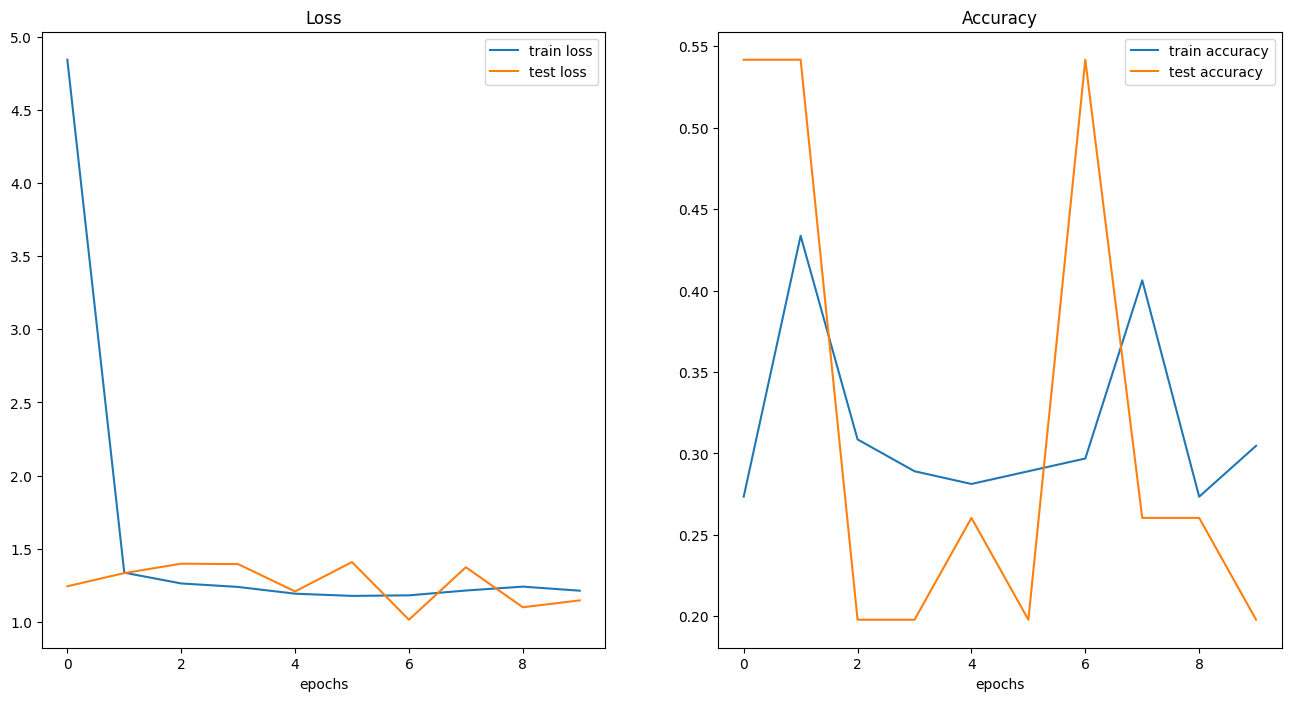

In [56]:
plot_loss_curves(results)